自然语言处理是计算机科学领域与人工智能领域中的一个重要方向。它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法【引用自[百度百科](https://baike.baidu.com/item/%E8%87%AA%E7%84%B6%E8%AF%AD%E8%A8%80%E5%A4%84%E7%90%86/365730?fr=aladdin)】。它是一种交叉学科，融合了计算机学、语言学、统计学、数学等学科知识。近年来随着机器学习技术的发展，自然语言处理模型也取得了一系列的进展，特别是在在语音文字转换、机器翻译、情感分析、文本分类等方向有了突破性的工作。

文本分类是自然语言处理，也可以说是信息检索里面的一部分。通过分析文本的标题、标签、内容等信息，确定文本的类别。比如垃圾邮件识别就是一种文本分类，利用模型分析邮件内容以区分正常邮件和垃圾邮件；还有新闻分类，根据新闻所谈论的内容，分为政治、经济、体育等类。建立高效准确的文本自动分类系统，能够有效管理各类文档，滤除无关信息以提升工作效益。

文本分类里面有三个重要的步骤：
- 1.文本清洗。去除与文本主要意思无关的符号、空格、空行，对文本进行分词。
- 2.文本表达。文本中提取特征，将文本符号转换成具有数学意义的矩阵、向量等表达方式，以作为分类算法的输入。
- 3.分类。采用监督学习方法，训练样本数据建立分类模型。

下面结合电影评论数据分类案例来讲解文本分类的这三个流程实施过程。但是之前需要对文本数据特点进行分析，以对应设计预处理方法和分类模型。

## 1.文本特点分析
电影评论数据可以直接通过nltk工具包直接获取，里面可以读取每篇评论内容、感情色彩以及单词。部分代码参考了CSDN博客http://blog.csdn.net/sinat_20791575/article/details/58661827 。

In [251]:
import nltk
import numpy as np
from nltk.corpus import movie_reviews

In [252]:
categories = movie_reviews.categories()
categories

['neg', 'pos']

电影评论从感情色彩上分为积极与负面两种类型

In [253]:
print('评论数量：', len(movie_reviews.fileids()))

评论数量： 2000


In [254]:
print('积极评论数量：', len(movie_reviews.fileids('pos')))
print('负面评论数量：', len(movie_reviews.fileids('neg')))

积极评论数量： 1000
负面评论数量： 1000


两种类型的数据是均衡的。下面我们查看第一个文件数据。

In [255]:
first = movie_reviews.fileids()[0]
movie_reviews.open(first).read()[:400]

'plot : two teen couples go to a church party , drink and then drive . \nthey get into an accident . \none of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . \nwhat\'s the deal ? \nwatch the movie and " sorta " find out . . . \ncritique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . \nwhich i'

可以看到当前文档除了单词之外还有标点符号，数字换行符等。在后面的处理中，我们可以将这些标点符号看成是没有意义的去除掉，也可以保留下来作为一个符号进行分析，特别是问号、感叹号也包含一定感情色彩。

**注意，一般读取的文档内容都是句子或者段落的长文本，需要进行分词。**

这里我们保留所有的符号，下面我们通过nltk工具获取每篇文章的单词以及对应的情感标签。nltk已经对文本进行了分词，但是为了演示完整流程，我们使用原始的文本，将原始的长文本分成单词和标点符号序列；分词时还可以分成2元组、3元组(n-gram)，比如“machine learning"、“a good dog”。对于中文稍微有些复杂，因为没有空格来区分词组，比如“今天我买了一件衣服”，每个汉字可以当做一个词，但是根据常识应该分为“今天”、“我”、“买了”、“一件”、“衣服”。

In [256]:
#读取每篇评论及其对应的标签
document_label_pairs = [(movie_reviews.raw(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]


In [257]:
#随机打乱次序
np.random.shuffle(document_label_pairs)

In [258]:
documents, labels = list(zip(*document_label_pairs))

## 2.文本清洗

文本清洗可以看成是数据预处理。一般有两项工作：
- 去除无意义符号。文本一般还有文字、标点符号、空格、数字，甚至有很多缩写、外文、错误的拼写，有的时候我们只需要处理单纯的文本比如单词或汉字，其他符号可以当做噪声去除掉。
- 对文本进行分词。将文本内容分成词组等形式。

在上面我们已经利用nltk工具直接获得了每篇评论的单词序列，这里再自己做一遍。

如果原始文件是一个字符串，比如我们将上文看作一个长字符串，并且需要去掉标点符号，我们可以使用Python工具完成。

### 2.1文本清洗示例
可以正则表达式来去掉标点符号。

In [259]:
#正则表达，去除表达符号
import re
text = document_label_pairs[0][0]
#指定需要去掉的标点符号
text = re.sub('[,.!:;#()-]', '', text)
text[:400]

'shakespeare in love is quite possibly the most enjoyable period piece ever made for the silver screen  \nit is both humorous and romantic in a very unique blend that can successfully entertain any audience for the nearly 2 and and a half hours that it occupies  \nthat is  however  not to say it is a good film  a quality production or anything of the sort  \nshakespeare in love is an incredibly cheap '

In [260]:
#分词
print(text.split()[:20])

['shakespeare', 'in', 'love', 'is', 'quite', 'possibly', 'the', 'most', 'enjoyable', 'period', 'piece', 'ever', 'made', 'for', 'the', 'silver', 'screen', 'it', 'is', 'both']


### 2.2对电影评论数据进行文本清洗

In [261]:
#去掉标点符号
documents = [re.sub('[_,.!:;#()0-9]', '', text) for text in documents]

In [262]:
#英文单词分词
document_words = [text.split() for text in documents]

In [263]:
#统计单词频率
total_words = []
import itertools
total_words = list(itertools.chain.from_iterable(document_words))

In [264]:
#总共的单词频率
len(total_words)

1315218

In [265]:
#统计每个单词的频率
from collections import Counter
word_freq_dict = Counter(total_words)
len(word_freq_dict)

49856

我们可以看看“dog”这个单词的频率，并对高频率单词进行可视化。

In [266]:
word_freq_dict['dog']

232

In [267]:
from matplotlib import pyplot
%matplotlib inline
words, freqs = list(word_freq_dict.keys()), list(word_freq_dict.values())

In [268]:
freq_word_pair = list(zip(freqs, words))

In [269]:
#按照词频从高到低排序
freq_word_pair.sort(reverse=True)

<Container object of 20 artists>

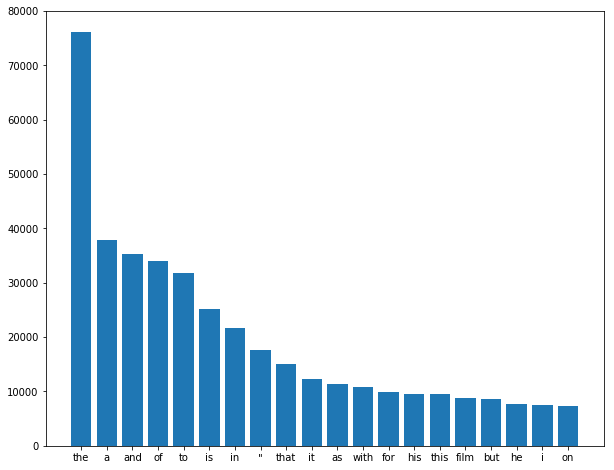

In [270]:
pyplot.figure(figsize=(10,8))
top_20 = freq_word_pair[:20]
freq20, words20 = list(zip(*top_20))
pyplot.bar(left=range(20), tick_label=words20, height=freq20)

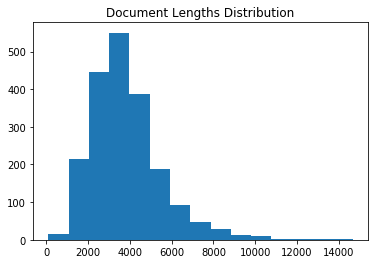

In [271]:
document_len = [len(doc) for doc in documents]
_ = pyplot.hist(document_len, bins=15)
_ = pyplot.title('Document Lengths Distribution')

分布图有些偏态。

### 2.3训练集和测试集划分



In [272]:
from sklearn.model_selection import train_test_split
doc_train, doc_test, label_train, label_test = train_test_split(documents, labels, test_size=0.3, random_state=111)

## 3.文本表达

文本数据特点是字符多、长度不一致，提取特征比一般的数据复杂。文本表达大致有三个方向，具体可参考[CSDN博客](http://blog.csdn.net/wangongxi/article/details/51591031)：
- 传统上的模型有词袋模型，也就是将文本看成单词的集合，不考虑单词的次序，比如"I love this dog"可以表达成[I, love, this, dog]，但是这样依然是文字符号，人能理解，计算机不能理解，所以需要转换成向量等形式以作为计算机的输入，比如将句子表示成词库中每个单词的频率组成的向量。通常文本库中的单词量很大，数万、数十万，很多单词只在部分文本中出现，所以文本表示的矩阵是维数很高的稀疏矩阵。
- 90年代有学者提出了[主题模型](http://blog.csdn.net/huagong_adu/article/details/7937616)，也就是将文档看成是若干主题的组合，比如一篇文章既讨论政治又讨论经济，而主题又是单词的组合。比较主流的有LSA方法，LDA方法等。
![Topic Model](http://img.my.csdn.net/uploads/201209/03/1346651772_3109.PNG)
- 近年来，随着深度学习的雄起，词嵌入（word embedding), 句子嵌入（sentence embedding）等概念和方法在文本处理中取得了突飞猛进。其理念是使用嵌入低维向量来表示单词、句子甚至文档，意义相近的单词距离较近，同理，意义相近的句子或文档向量距离也比较近。

**本次主要讨论词袋模型**。

词袋模型首先要建立一个单词库，一般是文档中所有单词的交集。词袋模型的表示有如下方法：
### 3.1单词是否出现在文档中
将所有文本单词（或词组）进行统计，建立所有文档单词库和频率字典，每篇文档可以表示为单词库中单词0，1值所组成的向量，1表示该单词在文档中存在，0表示不存在。比如：


s1 = 'I like dogs very very much.', s2 = 'He likes dogs too.' 单词库vocab=[I, like, he, likes, dogs, too, very, much]，那么
s1可以表示成向量[1, 1, 0, 0, 1, 0]，如下表：


| 句子 | I | like | he | likes | dogs | too| very | much
| - | :-: |  -: |  -: | -: |-: |-: |-: |-: |
| S1 | 1 | 1 | 0 | 0 | 1 | 0 | 1 | 1|
|S2 | 0 | 0 | 1 | 1 | 1 | 1 | 0 | 0|

可以直接使用sklearn中的CountVectorizer来建立词库并计算每个句子的向量。

In [273]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True)
corpus = [
     'This is the first document.',
     'This is the second second document.',
     'And the third one.',
     'Is this the first document?',
 ]

In [274]:
X = vectorizer.fit_transform(corpus)
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [275]:
vectorizer.vocabulary_

{'and': 0,
 'document': 1,
 'first': 2,
 'is': 3,
 'one': 4,
 'second': 5,
 'the': 6,
 'third': 7,
 'this': 8}

### 3.2单词频率值 
除了0，1值之外，句子还可以使用单词库中单词频率值表示向量。


| 句子 | I | like | he | likes | dogs | too| very | much
| - | :-: |  -: |  -: | -: |-: |-: |-: |-: |
| S1 | 1 | 1 | 0 | 0 | 1 | 0 | 2| 1|
|S2 | 0 | 0 | 1 | 1 | 1 | 1 | 0 | 0|

In [276]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1)
corpus = [
     'This is the first document.',
     'This is the second second document.',
     'And the third one.',
     'Is this the first document?',
 ]

In [277]:
X = vectorizer.fit_transform(corpus)

In [278]:
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [279]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

词频向量中，出现频率比较高的单词影响比较大，比如在一篇文章中多次出现医学、医院等词组的话，该篇很容易被划分为医学类；但是还有一些词，比如冠词“the”、“a”还有动词“do”、“make”、“come”几乎在每篇文章中大量出现，可以说对分类没有意义，但是频率又非常高。

### 3.3TFIDF表示方法
为了解决高频率单词这个问题，学者又提出了
TfIdf(term frequency, inversed document frequency)模型来表达文本，既考虑单词在某篇文章中的词频(term frequency)，又考虑该单词出现在所有文档上的频率(document frequency, 也就是出现该单词的文档数量)。TfIdf值计算公式如下：
$$tf = \frac {单词在当前文档中频率}{该文档中所有单词频率和}$$
$$idf = log(\frac {文档总数量}{出现该单词的文档数量})$$

$$tfidf = tf*idf$$
比如100篇文档，单词“make”在第一篇文档中出现的频率为10，有50篇文档里面有该单词，那么该文档中单词“make”的词频为10，单词总频数为680， document frequency=50。
$$tfid = 10/680 * log(100/50)=0.0102$$
当然，上述公式定义不唯一，具体可参考[Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)。

无论是统计词频还是计算tfidf值，都可以利用Python来一步一步实现，但是sklearn工具包提供了TfIdfVectorizer工具，能够将长文本直接分词统计词频计算TfIdf值。

In [280]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1)
corpus = [
     'This is the first document.',
     'This is the second second document.',
     'And the third one.',
     'Is this the first document?',
 ]

In [281]:
X = vectorizer.fit_transform(corpus)
print(X.toarray())

[[ 0.          0.43877674  0.54197657  0.43877674  0.          0.
   0.35872874  0.          0.43877674]
 [ 0.          0.27230147  0.          0.27230147  0.          0.85322574
   0.22262429  0.          0.27230147]
 [ 0.55280532  0.          0.          0.          0.55280532  0.
   0.28847675  0.55280532  0.        ]
 [ 0.          0.43877674  0.54197657  0.43877674  0.          0.
   0.35872874  0.          0.43877674]]


### 3.4电影评论TfIdf特征提取
利用sklearn工具包进行特征提取，去掉连接词，最低保留单词频率为2。

In [282]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2, stop_words='english', ngram_range=(1,1))

In [283]:
vectorizer.fit(doc_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [284]:
doc_train_vec = vectorizer.transform(doc_train)
doc_test_vec = vectorizer.transform(doc_test)

In [285]:
print('Training data Shape:', doc_train_vec.shape)
print('Testing data Shape:', doc_test_vec.shape)

Training data Shape: (1400, 19798)
Testing data Shape: (600, 19798)


In [286]:
import pandas as pd
data = pd.DataFrame(doc_train_vec.toarray())

In [287]:
data.columns = vectorizer.get_feature_names()
data.index = ['doc'+str(i+1) for i in range(len(data))]
data.head()

,aa,aaliyah,aardman,aaron,abandon,abandoned,abandoning,abandonment,abandons,abby,...,zoo,zoologist,zoom,zooming,zooms,zorg,zorro,zucker,zuko,zwick
doc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


这是个很庞大的稀疏矩阵，所以sklearn将之存储到稀疏矩阵里。

## 4.分类

这是一个监督学习里面的二元分类问题，分类的方法可以采用传统的统计机器学习方法比如决策树、朴素贝叶斯、逻辑回归、提升树等；也可以使用多层神经网络。

### 4.1朴素贝叶斯
我们首先使用经典的朴素贝叶斯方法进行分类，假设单词的条件概率都是独立的，计算每个类别单词出现的条件概率，每个文本的条件概率就是每个单词的条件概率之积。

In [288]:
import time
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

In [289]:
def train_test(clf):
    start = time.time()
    #训练
    clf.fit(doc_train_vec, label_train)
    end = time.time()
    print('训练时间：{:.3f}'.format(end-start))
    #预测
    preds = clf.predict(doc_test_vec)
    #计算准准确率
    #Micro F1
    print('Micro F1: {:.3f}'.format(f1_score(label_test, preds, average='micro')))

In [290]:
clf = MultinomialNB()
train_test(clf)

训练时间：0.005
Micro F1: 0.825


我们可以看看，哪些标签为'pos'类别文章中哪些特征单词的条件概率大。

In [297]:
for l in range(2):
    print(clf.classes_[l])
    con_prob1 = clf.feature_log_prob_[l, :]
    top_k = con_prob1.argsort()[-20:][::-1]
    temp_words = []
    for i in top_k:
        temp_words.append(vectorizer.get_feature_names()[i])
    
    print(temp_words)

neg
['film', 'movie', 'like', 'just', 'bad', 'good', 'time', 'plot', 'story', 'action', 'character', 'characters', 'really', 'make', 'don', 'big', 'little', 'doesn', 'scene', 'films']
pos
['film', 'movie', 'like', 'story', 'life', 'good', 'just', 'time', 'character', 'films', 'characters', 'way', 'does', 'best', 'man', 'great', 'people', 'new', 'love', 'really']


可以看到负面评价中有Bad， don't， doesn't等单词，而正面评价中有good, best, great, love等单词。

### 4.2 集成方法
还可以尝试集成方法，三个臭皮匠赛过诸葛亮。

In [307]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#clf_ad = AdaBoostClassifier(n_estimators=100, learning_rate=2).fit(X_train_tfidf, y_train)
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=4)
clf_ada = AdaBoostClassifier()
train_test(clf_rf)

训练时间：0.376
Micro F1: 0.797


In [308]:
train_test(clf_ada)

训练时间：1.905
Micro F1: 0.760


使用默认参数的继承方法效果并不明显。

### 4.3多层神经网络

In [309]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(80,20), max_iter=300, alpha=1e-4,
                    solver='sgd', verbose=False, tol=5e-5, random_state=1,
                    learning_rate_init=.1)
train_test(mlp)

训练时间：29.318
Micro F1: 0.862


神经网络的效果要好于前面提到的模型，但是训练耗费时间较多。